In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
env = "Varinia"

In [2]:
if env == "Sky":
    data_path_1='../Expert_response/all_HIT_answer.csv'
    data_path_2='../Expert_response/master_all_responses_May-14-2023_to_May-18-2023_Dan.csv'

else:
    data_path_1=r'C:\Users\varin\PycharmProjects\amazon-lameness-phase2\Expert_response\all_HIT_answer.csv'
    data_path_2=r'C:\Users\varin\PycharmProjects\amazon-lameness-phase2\Expert_response\master_all_responses_May-14-2023_to_May-18-2023_Dan.csv'
    data_path_3=r'C:\Users\varin\PycharmProjects\amazon-lameness-phase2\Expert_response\gs_response_Jun-04-2023.csv'

df_1= pd.read_csv(data_path_1)
df_2= pd.read_csv(data_path_2)
df_3= pd.read_csv(data_path_3)

In [3]:
def process_data(df_1, df_2):
    # Remove all positive and negative attention checks, keep only 1 copy of the positive attention check
    all_test_q = df_1[(df_1['question_type'] != "neg_attention") & (df_1['question_type'] != "pos_attention_easy")].copy()
    pos_attention_q = df_1[df_1['question_type'] == "pos_attention_easy"].head(1).copy()

    # Concatenate the dataframes and reset the index
    all_q = pd.concat([all_test_q, pos_attention_q], ignore_index=True)
    all_q.reset_index(drop=True, inplace=True)

    # Select the desired columns and convert question_num to int
    all_q2 = all_q[['cow_L', 'cow_R', 'question_num', 'HIT']].copy()
    all_q2.loc[:, 'question_num'] = all_q2['question_num'].str[1:].astype(int)

    # Select the columns for response dataframe
    all_q_col = [f"q{i}" for i in range(1, 13)]
    all_col = all_q_col.copy()
    all_col.append('HIT')

    # Get the response dataframe
    response = df_2[all_col].copy()

    return all_q2, response

In [4]:
def reshape_and_remove_nan(df):
    df_melted = df.melt(id_vars='HIT',
                        value_vars=['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12'],
                        var_name='question_num',
                        value_name='response')
    df_melted['question_num'] = df_melted['question_num'].str[1:].astype(int)
    df_melted = df_melted.dropna()
    return df_melted

In [5]:
def process_and_merge(df_1, df_2):
    all_q2, response = process_data(df_1, df_2)
    response_melted = reshape_and_remove_nan(response)
    merged_df = all_q2.merge(response_melted, on=['HIT', 'question_num'], how='inner')
    merged_df2 = merged_df[['cow_L', 'cow_R', 'response']]

    return merged_df2

In [6]:
final_df=process_and_merge(df_1, df_2)
display(final_df)

C:\Users\varin\AppData\Local\Temp\ipykernel_18252\2410287281.py:12: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  all_q2.loc[:, 'question_num'] = all_q2['question_num'].str[1:].astype(int)


,cow_L,cow_R,response
0,6029,7138,-1.0
1,5087,4008,-3.0
2,6092,7114,0.0
3,6053,6088,1.0
4,4035,7060,-1.0
...,...,...,...
430,5087,5064,-1.0
431,6046,4035,2.0
432,7109,7153,-1.0
433,6068,5118,-1.0


In [7]:
def simple_responses(df):
    N = df.shape[0]
    matrix = []
    for i in range(N):
        aux_df = df.iloc[[i]]
        cow_L = aux_df.at[i, 'cow_L']
        cow_R = aux_df.at[i, 'cow_R']
        response = aux_df.at[i, 'response']
        if response == 0:
            row = np.concatenate(([cow_L], [cow_R], [0]))
        elif response < 0:
            row = np.concatenate(([cow_L], [cow_R], [-1]))
        else:
            row = np.concatenate(([cow_L], [cow_R], [1]))
        matrix.append(row.tolist())
    new_df = pd.DataFrame(matrix)
    new_df.columns = ['cow_L', 'cow_R', 'response']

    return new_df

In [8]:
responses=simple_responses(final_df)
display(responses)

,cow_L,cow_R,response
0,6029,7138,-1
1,5087,4008,-1
2,6092,7114,0
3,6053,6088,1
4,4035,7060,-1
...,...,...,...
430,5087,5064,-1
431,6046,4035,1
432,7109,7153,-1
433,6068,5118,-1


In [9]:
def list_cows(df):
    first_cow=df.loc[0,'cow_L']
    aux_df=df[df['cow_L']==first_cow]
    cows_1=list(aux_df['cow_R'])
    aux_df=df[df['cow_R']==first_cow]
    cows_2=list(aux_df['cow_L'])
    for i in cows_2:
        cows_1.append(i)
    cows_1.append(first_cow)
    return cows_1

In [10]:
cow_order=list_cows(responses)
print(cow_order)
print(len(cow_order))

[7138, 6062, 8083, 7128, 6025, 7153, 4035, 6092, 4026, 6086, 6094, 7060, 7116, 6088, 7163, 5064, 6095, 7136, 7114, 4008, 7064, 6053, 5118, 6096, 7109, 6046, 6068, 5087, 7045, 6029]
30


In [36]:
def matrix_comparison(df):
    cow_order=list_cows(df)
    num_cows=len(cow_order)
    data_comp=[]
    for i in range(num_cows):
        data_comp_row=[]
        for j in range(num_cows):
            if (i==j):
                data_comp_row.append(np.nan)
            else:
                aux=df[(df['cow_L']==cow_order[i])|(df['cow_R']==cow_order[i])]
                aux=aux[(aux['cow_L']==cow_order[j])|(aux['cow_R']==cow_order[j])]
                #print(aux)
                cow_L=aux['cow_L'].to_numpy()
                cow_R=aux['cow_R'].to_numpy()
                response=aux['response'].to_numpy()
                if(response[0]==0):
                    data_comp_row.append(0.5)
                else:
                    if(cow_L[0]==cow_order[i]):
                        if(response[0]<0):
                            data_comp_row.append(1)
                        else:
                            data_comp_row.append(0)
                    else: #aux['cow_L']==cow_order[j]
                        if(response[0]<0):
                            data_comp_row.append(0)
                        else:
                             data_comp_row.append(1)
        data_comp.append(data_comp_row)
    return data_comp

In [42]:
data_comparison = matrix_comparison(responses)



[[nan, 1, 0.5, 0, 1, 1, 0, 1, 0, 0, 0, 0.5, 0, 0, 1, 0, 0.5, 0, 0.5, 0, 0.5, 0.5, 1, 0, 0, 1, 1, 0, 0.5, 0], [0, nan, 1, 0.5, 0, 0, 0, 0.5, 0, 1, 0.5, 1, 0, 0, 0.5, 1, 0.5, 0.5, 1, 0, 0.5, 0, 1, 0, 0, 1, 1, 0, 1, 1], [0.5, 0, nan, 0.5, 1, 0, 1, 1, 0.5, 0, 1, 1, 0, 0, 1, 0.5, 0, 1, 1, 0, 1, 0.5, 0.5, 0, 0, 1, 1, 0, 0, 1], [1, 0.5, 0.5, nan, 1, 1, 0, 0.5, 1, 1, 0, 1, 0, 0, 1, 0.5, 0, 1, 0, 0, 1, 1, 0.5, 0.5, 1, 1, 1, 0, 1, 1], [0, 1, 0, 0, nan, 1, 0, 0.5, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0.5, 1, 0, 1, 1, 0.5, 1, 1, 1, 1, 0, 0.5, 1], [0, 1, 1, 0, 0, nan, 0, 0.5, 1, 0, 0, 0.5, 0, 0, 0.5, 0.5, 0, 0.5, 0.5, 0, 1, 1, 0.5, 1, 0, 0.5, 0.5, 0, 0.5, 1], [1, 1, 0, 1, 1, 1, nan, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0.5, 0, 0.5, 0.5, 0.5, 0, nan, 0, 0, 0.5, 0.5, 0, 0, 0.5, 0.5, 0, 0.5, 0.5, 0, 0, 0.5, 0, 0, 0, 0.5, 0.5, 0, 0.5, 0.5], [1, 1, 0.5, 0, 1, 0, 0, 1, nan, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0.5, 1, 0, 1, 0.5, 0, 0.5, 0.5, 1, 1], [1, 0, 1, 0, 0, 1, 0, 1, 0, nan, 

In [55]:
def borda_count_rank(data_comparison):
    # Define the number of individuals
    num_individuals = len(cow_order)

    # Create an empty Borda count array
    borda_count = np.zeros(num_individuals)

    # Iterate over each individual
    for i in range(num_individuals):
        # Iterate over each pairwise comparison
        for j in range(num_individuals):
            if i != j:
                # Assign points based on the comparison result
                if data_comparison[i][j] > data_comparison[j][i]:
                    borda_count[j] += 1  # Individual i wins against Individual j
                elif data_comparison[i][j] < data_comparison[j][i]:
                    borda_count[j] -= 1  # Individual i loses against Individual j
                else:
                    borda_count[j] += 0.5  # Tie between Individual i and Individual j

    # Create a list of tuples (individual index, Borda count)
    borda_ranking = [(index, count) for index, count in enumerate(borda_count)]

    # Sort the ranking based on the Borda count in ascending order
    borda_ranking.sort(key=lambda x: x[1], reverse=False)
    cow_rank=[]
    for rank, (index, count) in enumerate(borda_ranking):
        cow_rank.append((cow_order[rank], count))
    return cow_rank


In [56]:
borda_ranking=borda_count_rank(data_comparison)
print(borda_ranking)
bc_order = [index for index, count in borda_ranking]
borda_counts = [count for index, count in borda_ranking]
print(borda_counts)
print(bc_order)

[(7138, -27.0), (6062, -25.5), (8083, -23.0), (7128, -21.0), (6025, -17.5), (7153, -4.0), (4035, -3.5), (6092, -3.0), (4026, -1.5), (6086, -1.0), (6094, 0.5), (7060, 1.5), (7116, 2.0), (6088, 3.5), (7163, 3.5), (5064, 4.0), (6095, 5.5), (7136, 5.5), (7114, 8.0), (4008, 9.5), (7064, 10.0), (6053, 12.0), (5118, 12.0), (6096, 13.5), (7109, 16.0), (6046, 20.5), (6068, 20.5), (5087, 21.0), (7045, 21.5), (6029, 21.5)]
[-27.0, -25.5, -23.0, -21.0, -17.5, -4.0, -3.5, -3.0, -1.5, -1.0, 0.5, 1.5, 2.0, 3.5, 3.5, 4.0, 5.5, 5.5, 8.0, 9.5, 10.0, 12.0, 12.0, 13.5, 16.0, 20.5, 20.5, 21.0, 21.5, 21.5]
[7138, 6062, 8083, 7128, 6025, 7153, 4035, 6092, 4026, 6086, 6094, 7060, 7116, 6088, 7163, 5064, 6095, 7136, 7114, 4008, 7064, 6053, 5118, 6096, 7109, 6046, 6068, 5087, 7045, 6029]


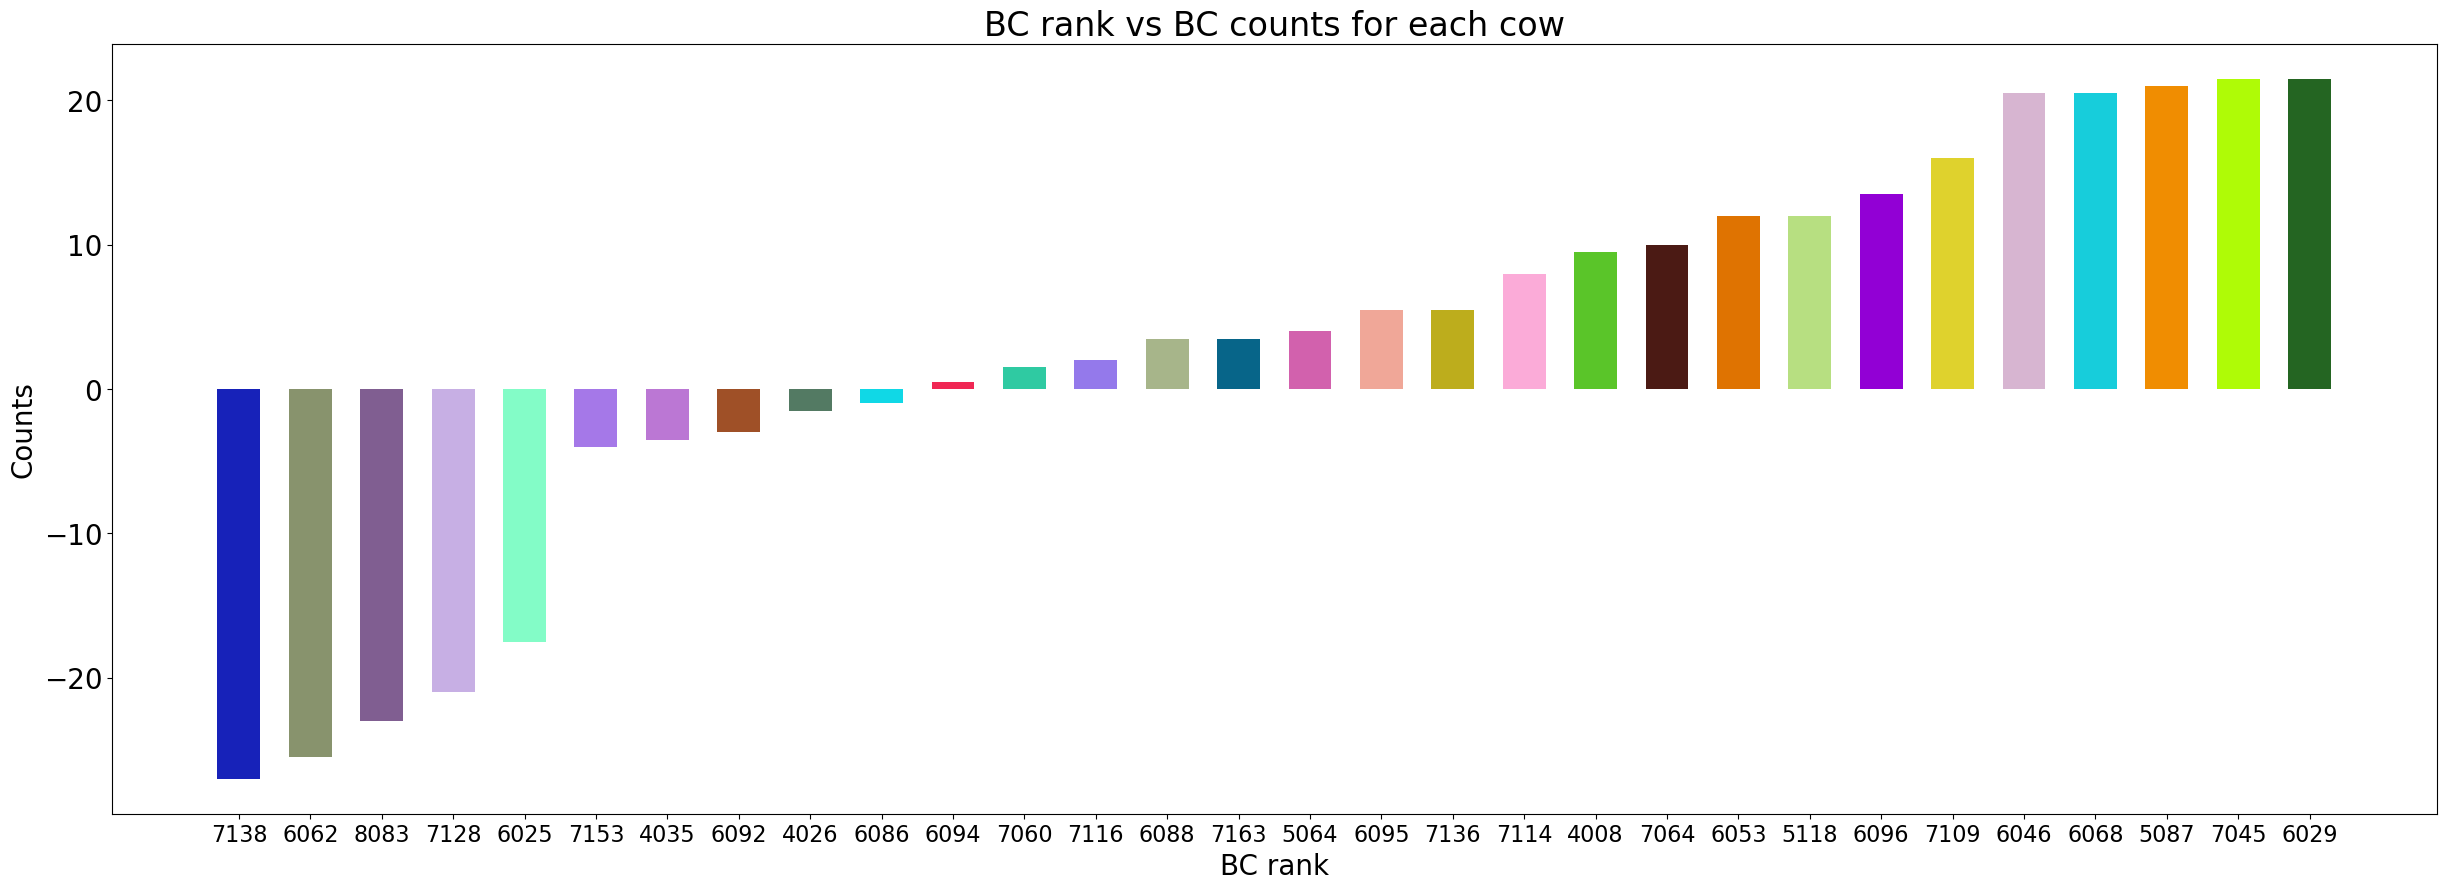

In [57]:
x=bc_order
y=borda_counts
string_cow = [str(item) for item in x]
plt.figure(figsize=(30, 10))
colors = np.random.rand(len(cow_order), 3)
plt.bar(string_cow, y, color=colors, width=0.6)

plt.xlabel('BC rank', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.title('BC rank vs BC counts for each cow', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=20)

# Specify the directory to save the image
save_dir = r'C:\Users\varin\PycharmProjects\amazon-lameness-phase2\rank_algorithm\bordacount\results'

# Save the plot to a file in the specified directory
file_name = 'borda_count.png'
save_path = f'{save_dir}/{file_name}'
plt.savefig(save_path)

plt.show()

In [62]:
#6095 not a 4
#6029 not a 4
#7128 not a 2
mg_vs_GS = pd.DataFrame(bc_order, columns=['BC ranked'])
N = mg_vs_GS.shape[0]
aux = []
for i in range(N):
    cow = mg_vs_GS.at[i, 'BC ranked']
    aux.append(list(df_3.loc[df_3['Cow'] == cow, 'GS'])[0])
mg_vs_GS['GS'] = aux
print(mg_vs_GS)

    BC ranked  GS
0        7138   2
1        6062   2
2        8083   3
3        7128   3
4        6025   2
5        7153   2
6        4035   3
7        6092   2
8        4026   2
9        6086   2
10       6094   2
11       7060   3
12       7116   2
13       6088   3
14       7163   2
15       5064   2
16       6095   3
17       7136   2
18       7114   2
19       4008   2
20       7064   2
21       6053   3
22       5118   2
23       6096   3
24       7109   2
25       6046   3
26       6068   2
27       5087   4
28       7045   2
29       6029   2


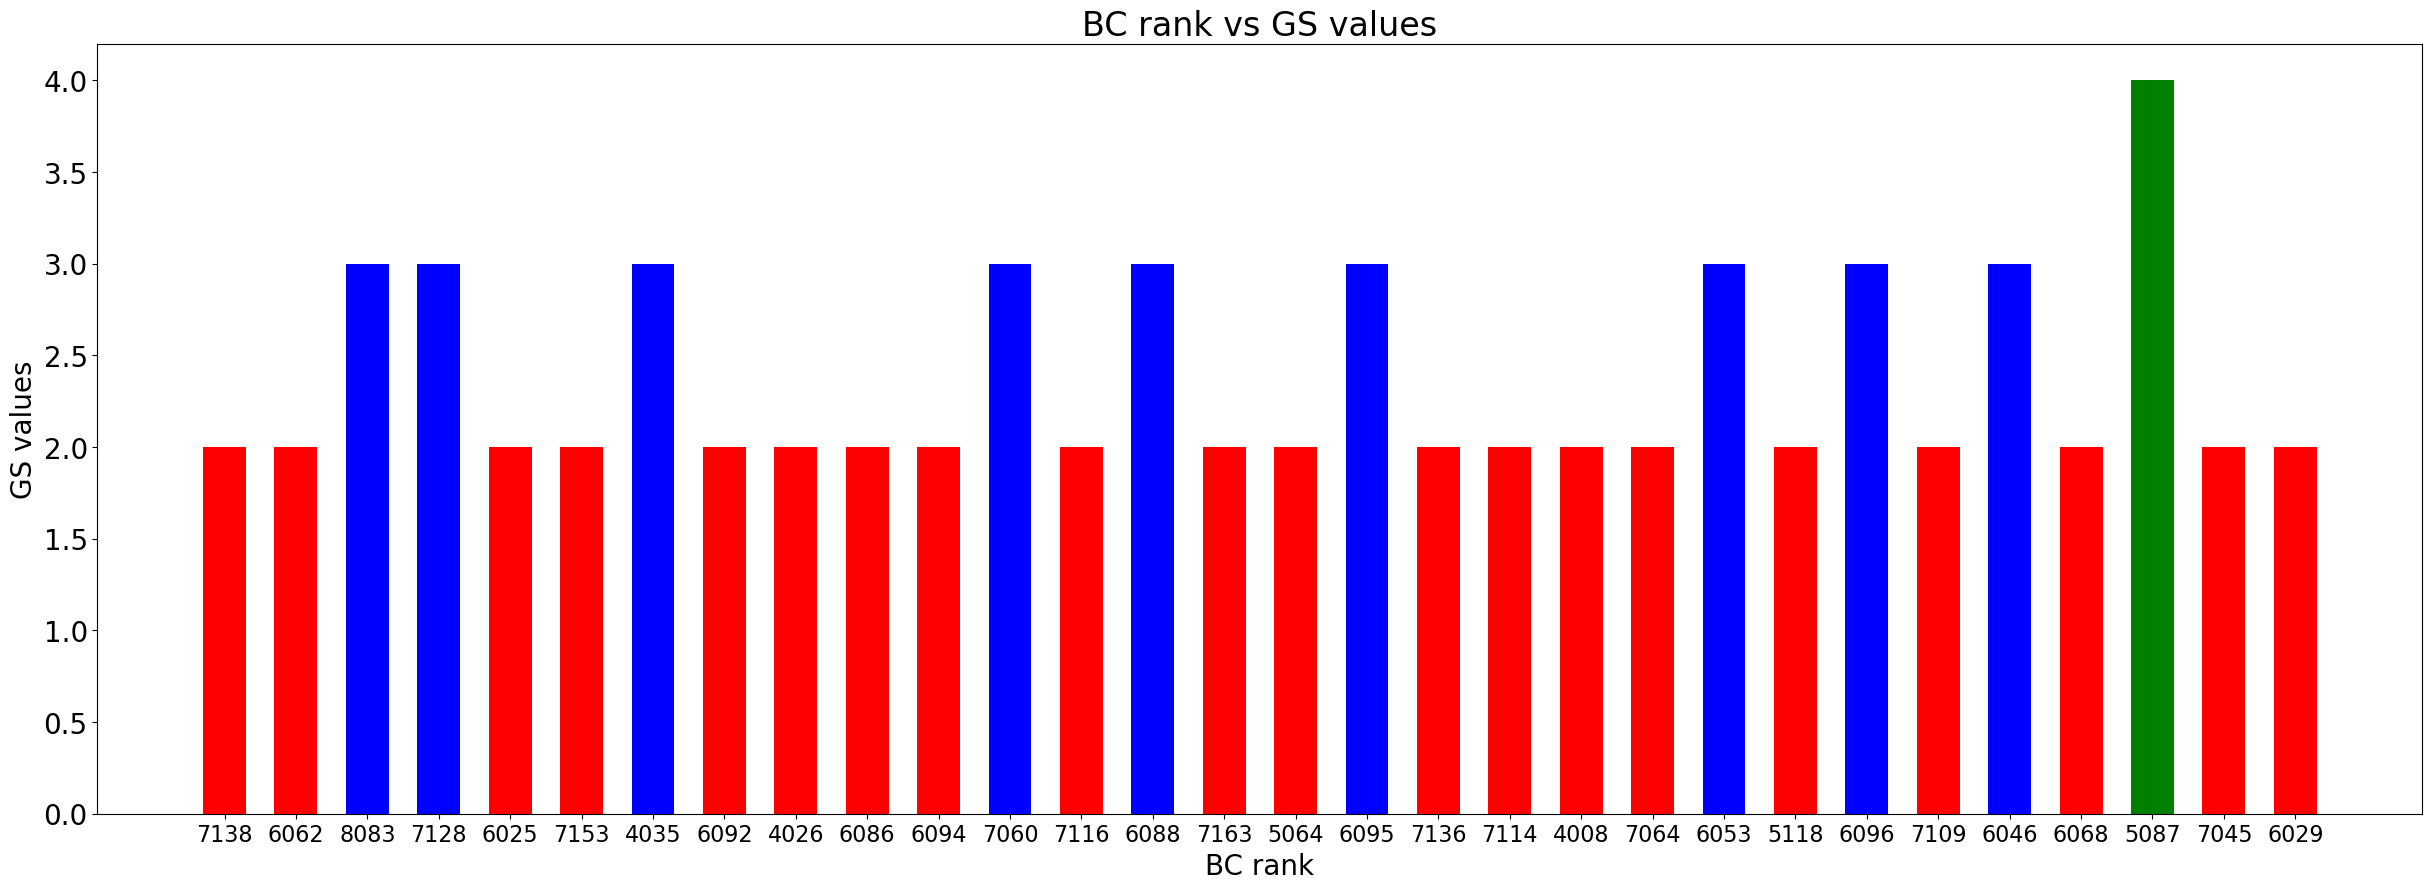

In [66]:
x=list(mg_vs_GS['BC ranked'])
y=list(mg_vs_GS['GS'])
string_cow = [str(item) for item in x]
# Get unique y-axis values
unique_values = np.unique(y)

# Define the colors for each unique y-axis value
colors = {'2': 'red', '3': 'blue', '4': 'green'}

plt.figure(figsize=(30, 10))

plt.bar(string_cow, y, color=[colors[str(val)] for val in y], width=0.6)

plt.xlabel('BC rank', fontsize=20)
plt.ylabel('GS values', fontsize=20)
plt.title('BC rank vs GS values', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=20)
# Save the plot to a file in the specified directory
file_name = 'BC_vs_GS.png'
save_path = f'{save_dir}/{file_name}'
plt.savefig(save_path)

plt.show()